# MPI calibration of a Grid5000 cluster

## Running the measurements

In [2]:
!python fabfile.py --deploy debian9-x64-min rennes tocornebize cluster paravance

[2018-06-29 13:46:33][INFO] [frontend] oarsub -t deploy  -l "{cluster in ('paravance')}/nodes=2,walltime=00:15:00" -r "2018-06-29 13:46:33"
[2018-06-29 13:46:41][INFO] [frontend] oarstat -fJ -j 1022596
[2018-06-29 13:46:47][INFO] [frontend] oarstat -fJ -j 1022596
[2018-06-29 13:46:58][INFO] [frontend] oarstat -fJ -j 1022596
[2018-06-29 13:46:59][INFO] Job(1022596)
[2018-06-29 13:46:59][INFO] Nodes: paravance-71.rennes.grid5000.fr and paravance-72.rennes.grid5000.fr
[2018-06-29 13:47:04][INFO] [frontend] kadeploy3 -k -f /var/lib/oar/1022596 -e debian9-x64-min
[2018-06-29 13:51:33][INFO] [allnodes] cd /tmp && hostname
[2018-06-29 13:51:34][INFO] [allnodes] cd /tmp && apt update && apt upgrade -y
[2018-06-29 13:51:38][INFO] [allnodes] cd /tmp && apt install -y build-essential python3 python3-dev zip make git time libopenmpi-dev openmpi-bin libxml2 libxml2-dev hwloc pciutils net-tools
[2018-06-29 13:54:48][INFO] [allnodes] cd /tmp && git clone https://gitlab.inria.fr/simgrid/platform-calib

In [3]:
!ls *zip

paravance-71-paravance-72_2018-06-29_1022596.zip


In [4]:
!unzip -l 'paravance-71-paravance-72_2018-06-29_1022596.zip'

Archive:  paravance-71-paravance-72_2018-06-29_1022596.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
        0  06-29-2018 13:55   exp/
  2413100  06-29-2018 13:55   exp/exp_PingPong.csv
  1239650  06-29-2018 13:55   exp/exp_Isend.csv
    60502  06-29-2018 13:55   exp/exp_Iprobe.csv
    52311  06-29-2018 13:55   exp/exp_Test.csv
       35  06-29-2018 13:55   exp/exp_Wtime.csv
  1190432  06-29-2018 13:55   exp/exp_Recv.csv
        0  06-29-2018 13:55   information/
        0  06-29-2018 13:55   information/paravance-71.rennes.grid5000.fr/
    35778  06-29-2018 13:55   information/paravance-71.rennes.grid5000.fr/cpuinfo.txt
    52006  06-29-2018 13:55   information/paravance-71.rennes.grid5000.fr/lspci.txt
    45046  06-29-2018 13:55   information/paravance-71.rennes.grid5000.fr/topology.xml
    13932  06-29-2018 13:55   information/paravance-71.rennes.grid5000.fr/topology.pdf
      367  06-29-2018 13:55   information/paravance-71.rennes.grid5000.fr/environmen

## Data exploration

In [1]:
from extract_archive import extract_zip, clean_dataset

result = extract_zip('paravance-71-paravance-72_2018-06-29_1022596.zip')
result.keys()

dict_keys(['exp/exp_PingPong.csv', 'exp/exp_Isend.csv', 'exp/exp_Iprobe.csv', 'exp/exp_Test.csv', 'exp/exp_Wtime.csv', 'exp/exp_Recv.csv'])

In [2]:
result['exp/exp_Recv.csv'].head()

,op,msg_size,start,duration,experiment,type,deployment,index
0,MPI_Recv,765921,0.012125,0.001524,paravance-71-paravance-72,exp/exp_Recv.csv,debian9-x64-min,0
1,MPI_Recv,765921,0.019462,0.001187,paravance-71-paravance-72,exp/exp_Recv.csv,debian9-x64-min,1
2,MPI_Recv,765921,0.026478,0.001257,paravance-71-paravance-72,exp/exp_Recv.csv,debian9-x64-min,2
3,MPI_Recv,765921,0.033425,0.001211,paravance-71-paravance-72,exp/exp_Recv.csv,debian9-x64-min,3
4,MPI_Recv,765921,0.040408,0.001210,paravance-71-paravance-72,exp/exp_Recv.csv,debian9-x64-min,4


In [3]:
import pandas

# Special processing for the Pingpong dataset
df_pingpong = result['exp/exp_PingPong.csv']
pingpong_send = df_pingpong[df_pingpong.op=='MPI_Send'].reset_index(drop=True)
pingpong_recv = df_pingpong[df_pingpong.op=='MPI_Recv'].reset_index(drop=True)
df_pingpong = pandas.DataFrame(dict(op = 'PingPong',
                   msg_size = pingpong_send.msg_size,
                   start    = pingpong_send.start,
                   duration = pingpong_recv.duration + pingpong_send.duration
              ))

df_send = pingpong_send
df_isend = result['exp/exp_Isend.csv']
df_recv = result['exp/exp_Recv.csv']
df_wtime = result['exp/exp_Wtime.csv']
df_test = result['exp/exp_Test.csv']
df_iprobe = result['exp/exp_Iprobe.csv']

### MPI_Send

In [4]:
import pytree
import matplotlib.pyplot as plt

tmp = clean_dataset(df_send)
reg_send = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration).auto_simplify()
print(reg_send.breakpoints)
reg_send

[62793, 254743]


-inf < x ≤ 6.279e+04
	y ~ 7.091e-11x + 2.185e-06
6.279e+04 < x ≤ 2.547e+05
	y ~ 1.677e-10x + 4.797e-05
2.547e+05 < x ≤ inf
	y ~ 1.105e-09x + -8.334e-05

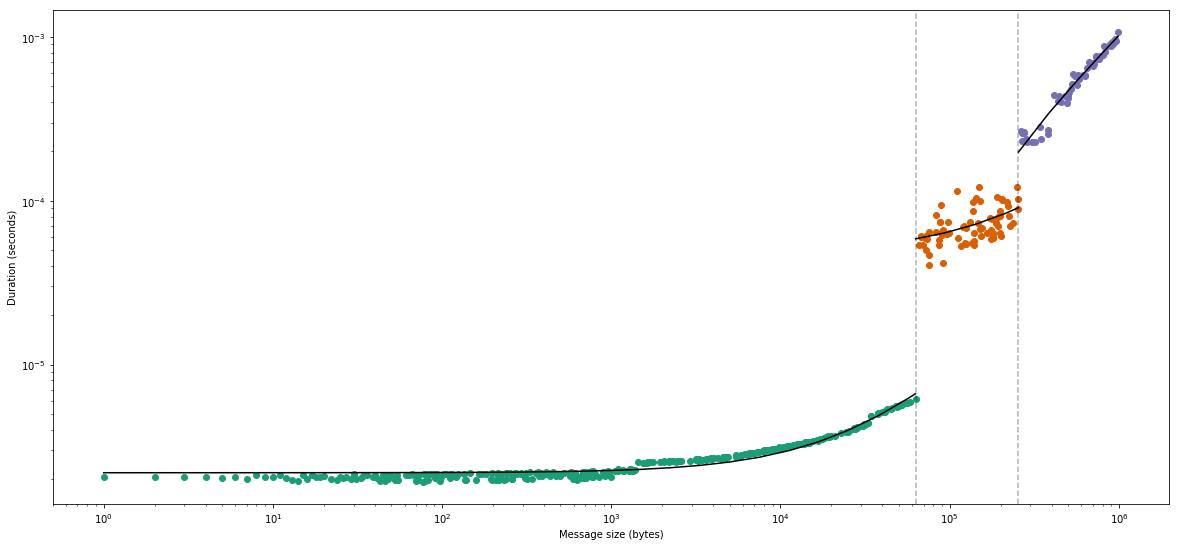

In [5]:
def draw_plot(reg, alpha=1):
    reg.plot_dataset(log=True, alpha=alpha)
    plt.xlabel('Message size (bytes)')
    plt.ylabel('Duration (seconds)')

draw_plot(reg_send)

### MPI_Isend

In [6]:
tmp = clean_dataset(df_isend)
reg_isend = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration).auto_simplify()
print(reg_isend.breakpoints)
reg_isend

[27912, 62793]


-inf < x ≤ 2.791e+04
	y ~ 7.402e-11x + 2.195e-06
2.791e+04 < x ≤ 6.279e+04
	y ~ 6.114e-11x + 2.366e-06
6.279e+04 < x ≤ inf
	y ~ 2.210e-13x + 2.620e-06

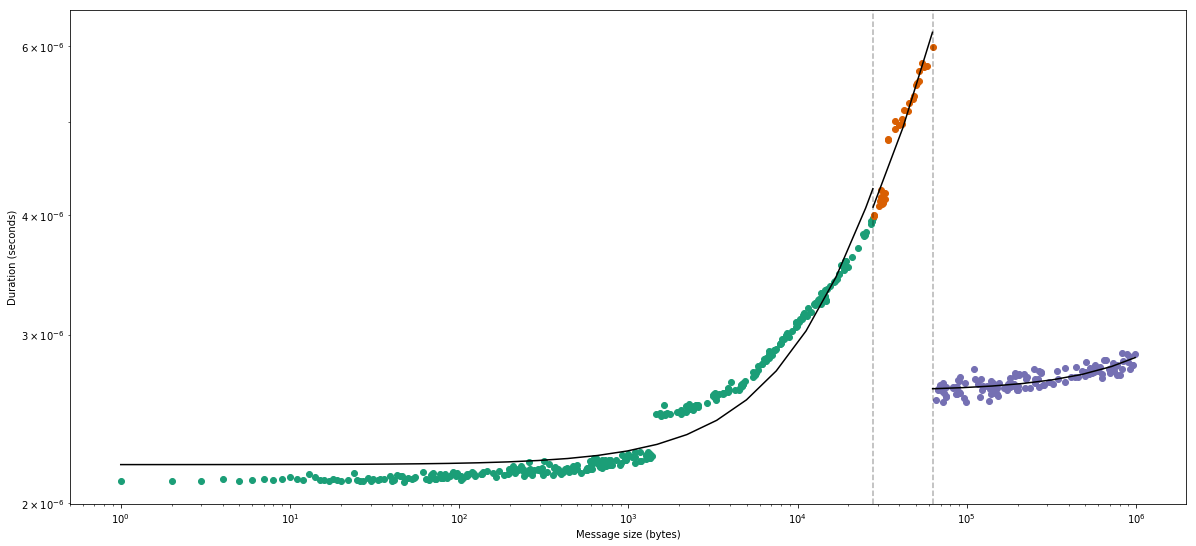

In [7]:
draw_plot(reg_isend)

### MPI_Recv

In [8]:
tmp = clean_dataset(df_recv)
reg_recv = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration)
print(reg_recv.breakpoints)
reg_recv = reg_recv.auto_simplify()
print(reg_recv.breakpoints)
reg_recv

[1382, 30603, 62793, 124510, 135970]
[62793, 135970]


-inf < x ≤ 6.279e+04
	y ~ 5.619e-10x + 6.248e-06
6.279e+04 < x ≤ 1.360e+05
	y ~ 1.073e-09x + 5.998e-05
1.360e+05 < x ≤ inf
	y ~ 1.235e-09x + 8.255e-05

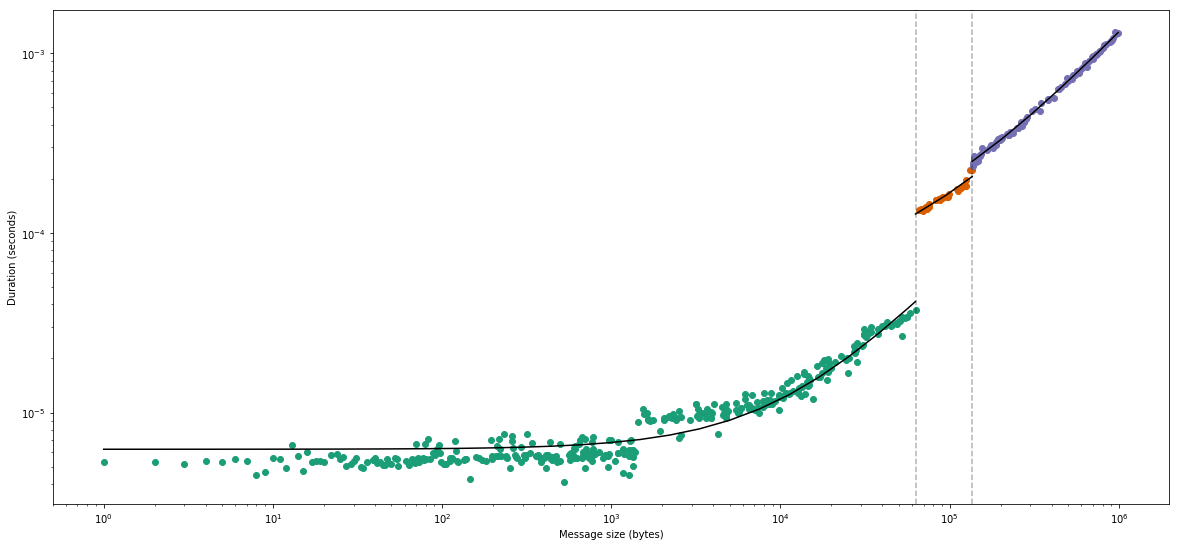

In [9]:
draw_plot(reg_recv)

### Pingpong

In [10]:
tmp = clean_dataset(df_pingpong)
reg_pingpong = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration).auto_simplify()
print(reg_pingpong.breakpoints)
reg_pingpong

[2191, 62793, 124703]


-inf < x ≤ 2.191e+03
	y ~ 2.600e-08x + 3.149e-05
2.191e+03 < x ≤ 6.279e+04
	y ~ 2.080e-09x + 6.800e-05
6.279e+04 < x ≤ 1.247e+05
	y ~ 1.971e-09x + 1.762e-04
1.247e+05 < x ≤ inf
	y ~ 2.318e-09x + 2.060e-04

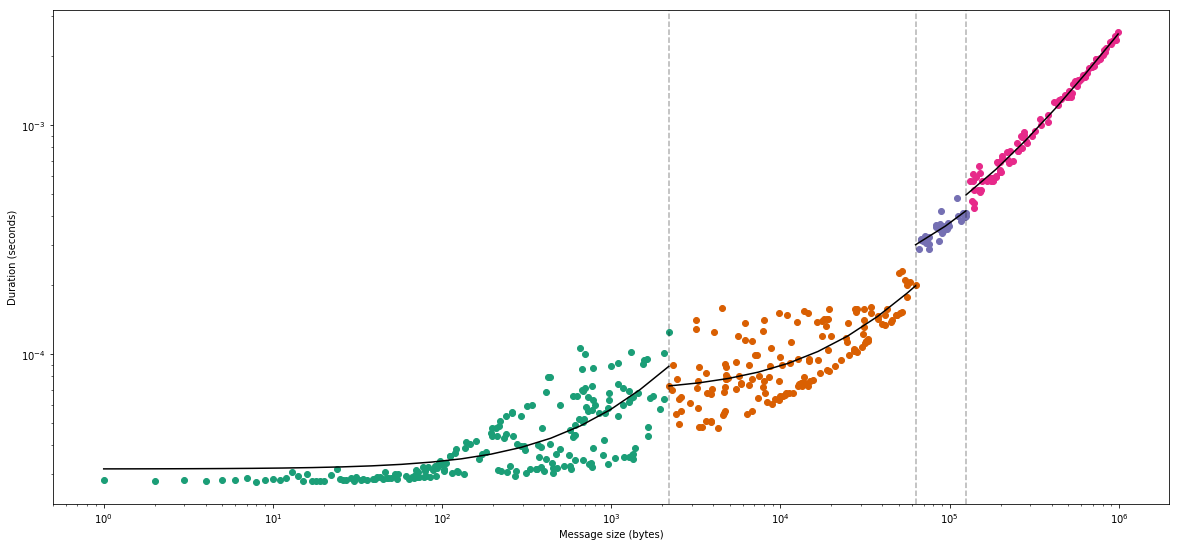

In [11]:
draw_plot(reg_pingpong)

## Better regressions

Let's use the same breakpoints everywhere and stop “cleaning” the datasets.

In [12]:
breakpoints = [1382] + reg_send.breakpoints
print(breakpoints)

[1382, 62793, 254743]


### MPI_Send

-inf < x ≤ 1.382e+03
	y ~ 1.399e-10x + 2.169e-06
1.382e+03 < x ≤ 6.279e+04
	y ~ 6.477e-11x + 2.517e-06
6.279e+04 < x ≤ 2.547e+05
	y ~ 1.899e-10x + 7.059e-05
2.547e+05 < x ≤ inf
	y ~ 1.160e-09x + -6.318e-05


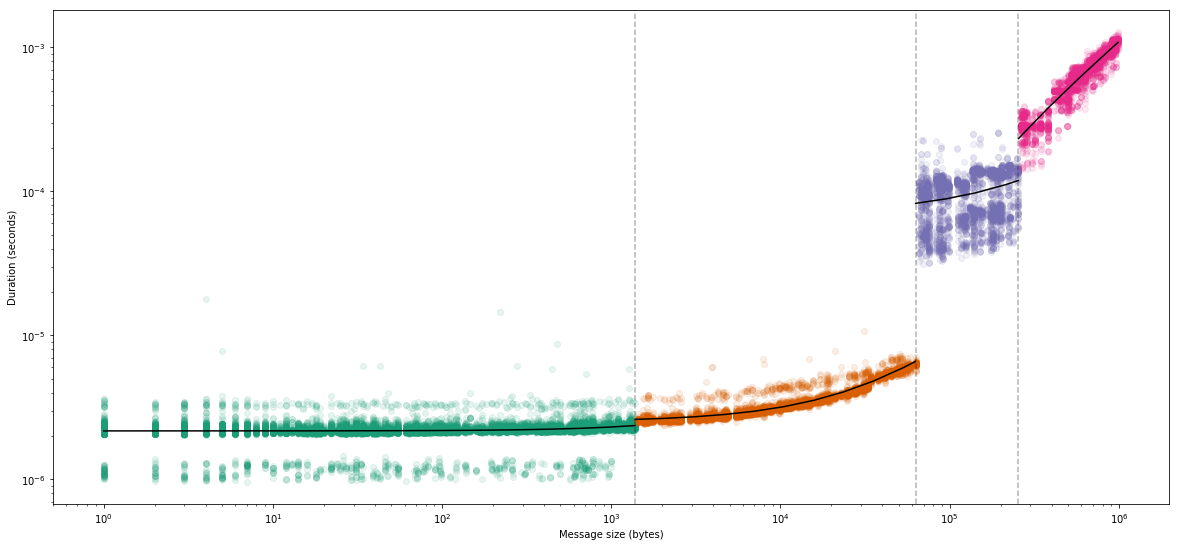

In [13]:
reg_send = pytree.compute_regression(x=df_send.msg_size, y=df_send.duration, breakpoints=breakpoints)
print(reg_send)
draw_plot(reg_send, alpha=0.1)

### MPI_Isend

-inf < x ≤ 1.382e+03
	y ~ 6.658e-11x + 2.738e-06
1.382e+03 < x ≤ 6.279e+04
	y ~ 6.012e-11x + 3.034e-06
6.279e+04 < x ≤ 2.547e+05
	y ~ -5.793e-14x + 3.309e-06
2.547e+05 < x ≤ inf
	y ~ 6.944e-13x + 3.004e-06


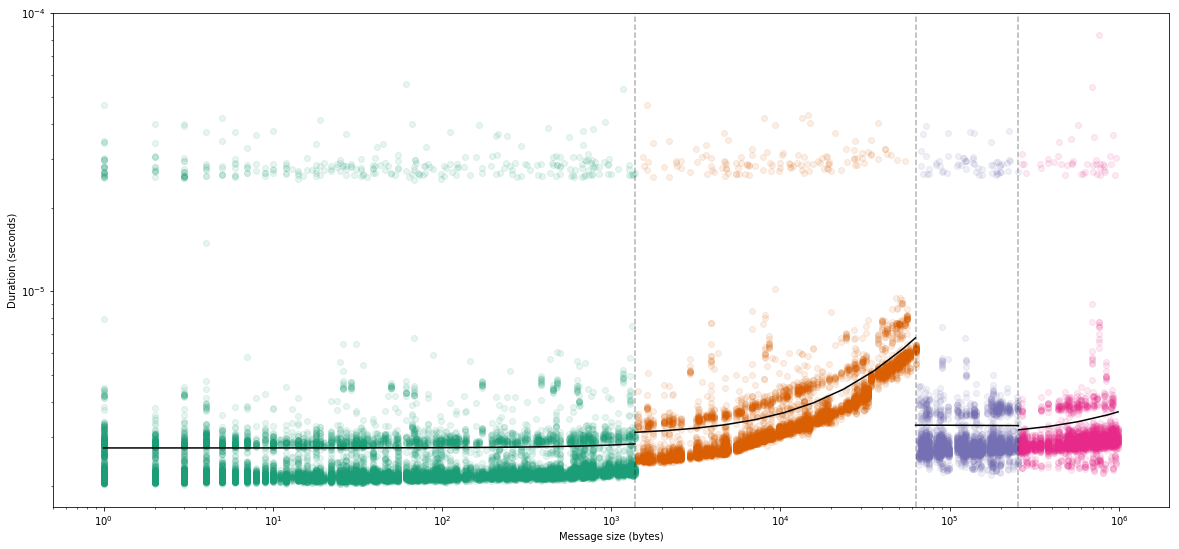

In [14]:
reg_isend = pytree.compute_regression(x=df_isend.msg_size, y=df_isend.duration, breakpoints=breakpoints)
print(reg_isend)
draw_plot(reg_isend, alpha=0.1)

### MPI_Recv

-inf < x ≤ 1.382e+03
	y ~ 4.202e-10x + 7.091e-06
1.382e+03 < x ≤ 6.279e+04
	y ~ 5.945e-10x + 1.012e-05
6.279e+04 < x ≤ 2.547e+05
	y ~ 1.615e-09x + 2.822e-05
2.547e+05 < x ≤ inf
	y ~ 1.243e-09x + 1.377e-04


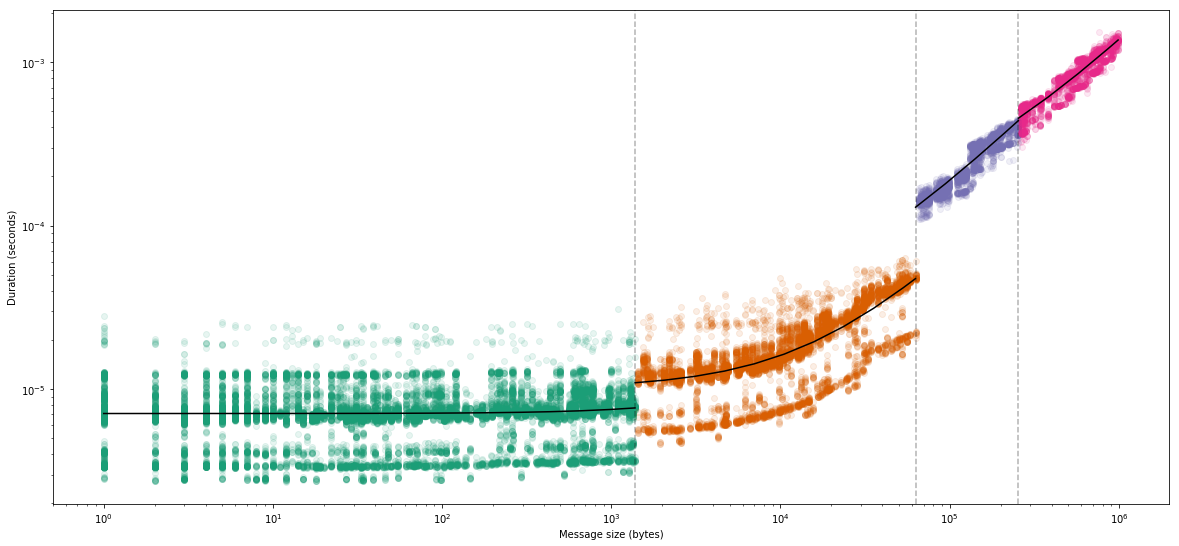

In [15]:
reg_recv = pytree.compute_regression(x=df_recv.msg_size, y=df_recv.duration, breakpoints=breakpoints)
print(reg_recv)
draw_plot(reg_recv, alpha=0.1)

### Pingpong

-inf < x ≤ 1.382e+03
	y ~ 3.464e-08x + 4.219e-05
1.382e+03 < x ≤ 6.279e+04
	y ~ 1.954e-09x + 8.766e-05
6.279e+04 < x ≤ 2.547e+05
	y ~ 2.865e-09x + 1.535e-04
2.547e+05 < x ≤ inf
	y ~ 2.298e-09x + 2.914e-04


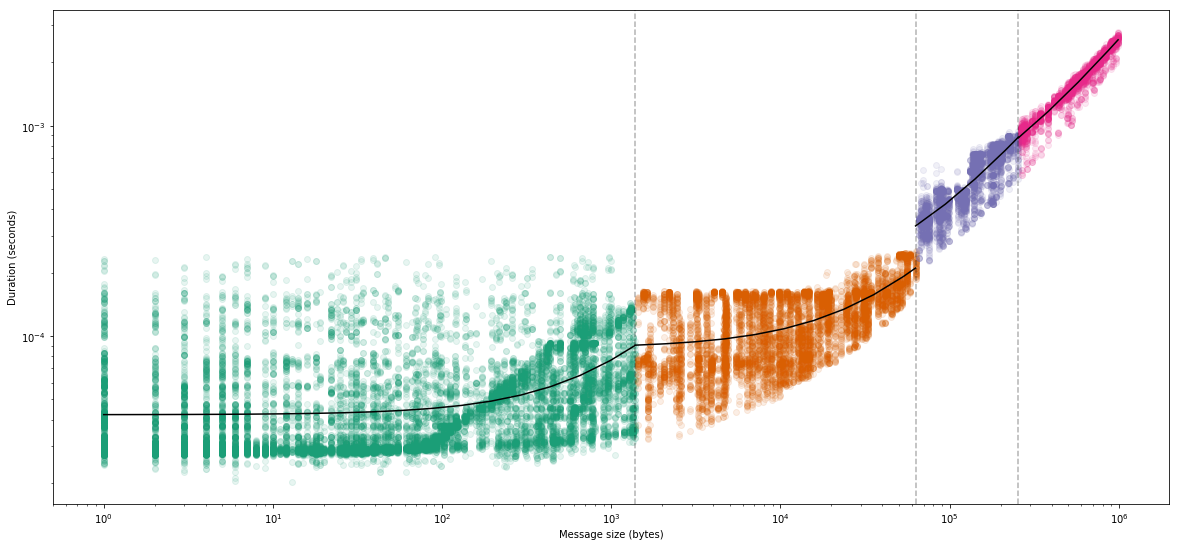

In [16]:
reg_pingpong = pytree.compute_regression(x=df_pingpong.msg_size, y=df_pingpong.duration, breakpoints=breakpoints)
print(reg_pingpong)
draw_plot(reg_pingpong, alpha=0.1)

In [17]:
df_reg_pingpong = reg_pingpong.to_pandas()
df_reg_recv = reg_recv.to_pandas()
df_reg_recv

,AIC,BIC,MSE,RSS,coefficient,intercept,max_x,min_x
0,-287007.191943,-286983.772665,7.472251e-12,1.356214e-07,4.202159e-10,0.000007,1.382000e+03,-inf
1,-125283.725245,-125262.617284,3.963017e-11,3.328934e-07,5.944742e-10,0.000010,6.279300e+04,1.382000e+03
2,-47354.426529,-47335.737995,8.731112e-10,3.274167e-06,1.614621e-09,0.000028,2.547430e+05,6.279300e+04
3,-30200.680446,-30182.868322,7.372752e-09,2.064370e-05,1.242814e-09,0.000138,inf,2.547430e+05


In [18]:
df_reg_transfer = pandas.DataFrame({'min_x': df_reg_pingpong.min_x,
                                    'max_x': df_reg_pingpong.max_x,
                                    'intercept': (df_reg_pingpong.intercept - df_reg_recv.intercept)/2,
                                    'coefficient': (df_reg_pingpong.coefficient - df_reg_recv.coefficient)/2,
                                   })
df_reg_transfer

,min_x,max_x,intercept,coefficient
0,-inf,1.382000e+03,0.000018,1.710958e-08
1,1.382000e+03,6.279300e+04,0.000039,6.797226e-10
2,6.279300e+04,2.547430e+05,0.000063,6.253376e-10
3,2.547430e+05,inf,0.000077,5.274776e-10
